In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path="/content/drive/MyDrive/FL/heart.disease.csv"

In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv(data_path)

In [ ]:
# Display the first 5 rows of the dataset
print("First 5 rows of the dataset:")
print(df.head())

# Display basic info about the dataset
print("\nDataset Info:")
print(df.info())

# Display summary statistics
print("\nSummary Statistics:")
print(df.describe())

First 5 rows of the dataset:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       1  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    float64
 1   sex       297 non-null    float64
 2   cp        297 non-null    float64
 3   trestbps

Target Class Distribution:
0 (No Heart Disease): 160 samples
1 (Heart Disease):    137 samples


<ipython-input-6-93db3be09508>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_counts.index, y=target_counts.values, palette="Set2")


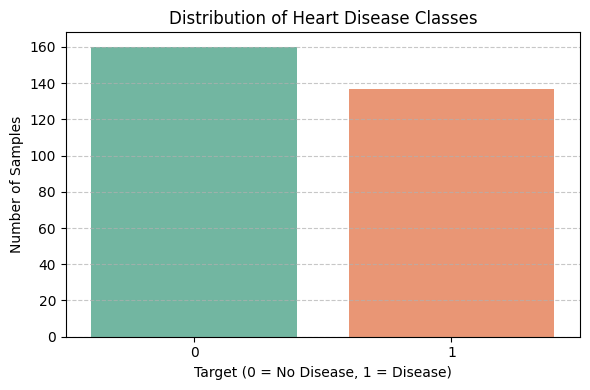

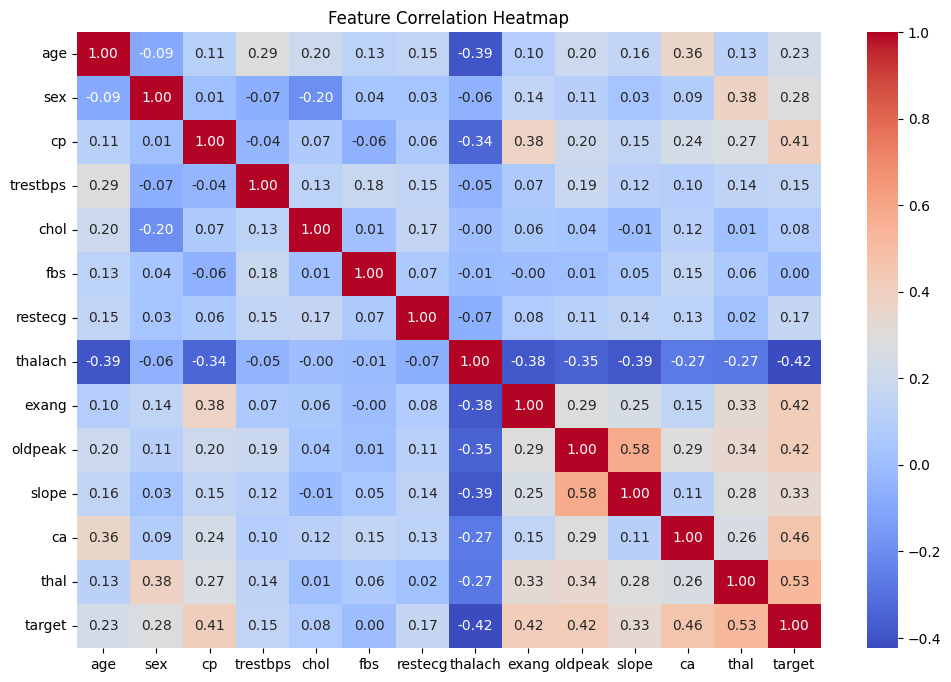

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each class (0 and 1)
target_counts = df['target'].value_counts().sort_index()

# Print the counts
print("Target Class Distribution:")
print(f"0 (No Heart Disease): {target_counts[0]} samples")
print(f"1 (Heart Disease):    {target_counts[1]} samples")

# Plot the distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, palette="Set2")
plt.title('Distribution of Heart Disease Classes')
plt.xlabel('Target (0 = No Disease, 1 = Disease)')
plt.ylabel('Number of Samples')
plt.xticks([0, 1])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import pearsonr

In [ ]:

# Convert all columns to numeric and binarize target
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')
df = df.dropna()
y = np.array((df["target"] > 0).astype(np.float32))
X_raw = df.drop(columns="target").values.astype(np.float32)
feature_names = df.drop(columns="target").columns.tolist()

In [ ]:
# Feature Selection Functions with Scores
def anova_fs(X, y, k=10):
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X, y)
    X_new = selector.transform(X)
    scores = selector.scores_
    selected_indices = selector.get_support(indices=True)
    return X_new, selected_indices, scores[selected_indices]

def chi2_fs(X, y, k=10):
    scaler = MinMaxScaler()  # Chi-square requires non-negative data
    X_scaled = scaler.fit_transform(X)
    selector = SelectKBest(score_func=chi2, k=k)
    selector.fit(X_scaled, y)
    X_new = selector.transform(X_scaled)
    scores = selector.scores_
    selected_indices = selector.get_support(indices=True)
    return X_new, selected_indices, scores[selected_indices]

def cc_fs(X, y, k=10):
    correlations = np.array([abs(pearsonr(X[:, i], y)[0]) for i in range(X.shape[1])])
    selected_indices = np.argsort(correlations)[::-1][:k]
    scores = correlations[selected_indices]
    return X[:, selected_indices], selected_indices, scores

# Placeholder for Genetic Algorithm (simplified correlation-based selection)
def ga_fs(X, y, k=10):
    return cc_fs(X, y, k)  # Using CC as a proxy for GA simplicity

In [ ]:
# Feature Extraction Functions
def pca_fe(X, n_components=5):
    extractor = PCA(n_components=n_components)
    return extractor.fit_transform(X)

def lda_fe(X, y, n_components=1):
    extractor = LDA(n_components=n_components)
    return extractor.fit_transform(X, y)

In [ ]:
# MLP Model for Federated Learning
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))


In [ ]:
# Training and Evaluation Functions
def train(model, loader, criterion, optimizer, epochs=20):
    model.train()
    for _ in range(epochs):
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

def average_models(models):
    new_model = MLP(models[0].fc1.in_features)
    new_state_dict = new_model.state_dict()
    for key in new_state_dict:
        new_state_dict[key] = torch.stack([m.state_dict()[key] for m in models], 0).mean(0)
    new_model.load_state_dict(new_state_dict)
    return new_model

def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            output = model(X_batch)
            preds = torch.argmax(output, dim=1)
            y_true.extend(y_batch.numpy())
            y_pred.extend(preds.numpy())
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0)
    }

In [ ]:

# Federated Learning Function with Feature Display
def run_federated_learning(X_raw, y, fs_method=None, fe_method=None, k_features=10):
    client_splits = np.array_split(np.random.permutation(len(X_raw)), 3)
    client_datasets = []

    # Display top features if FS method is specified
    if fs_method in ["anova", "chi2", "cc", "ga"]:
        X_full = X_raw
        if fs_method == "anova":
            X_fs, selected_indices, scores = anova_fs(X_full, y, k=k_features)
        elif fs_method == "chi2":
            X_fs, selected_indices, scores = chi2_fs(X_full, y, k=k_features)
        elif fs_method == "cc" or fs_method == "ga":
            X_fs, selected_indices, scores = cc_fs(X_full, y, k=k_features)
        feature_table = pd.DataFrame({
            "Feature": [feature_names[i] for i in selected_indices],
            "Score": scores
        })
        print(f"\nTop 10 Features for {fs_method.upper()}:")
        print(feature_table.to_string(index=False))

    for split in client_splits:
        X_client = X_raw[split]
        y_client = y[split]

        # Apply scaling based on FS method
        if fs_method == "anova":
            scaler = StandardScaler()
            X_client = scaler.fit_transform(X_client)
        elif fs_method == "chi2":
            scaler = MinMaxScaler()
            X_client = scaler.fit_transform(X_client)

        # Feature Selection
        if fs_method == "anova":
            X_fs, _, _ = anova_fs(X_client, y_client, k=k_features)
        elif fs_method == "chi2":
            X_fs, _, _ = chi2_fs(X_client, y_client, k=k_features)
        elif fs_method == "cc" or fs_method == "ga":
            X_fs, _, _ = cc_fs(X_client, y_client, k=k_features)
        else:
            X_fs = X_client

        # Feature Extraction
        if fe_method == "pca":
            X_fe = pca_fe(X_fs)
        elif fe_method == "lda":
            X_fe = lda_fe(X_fs, y_client)
        else:
            X_fe = X_fs

        # Train/Val Split
        X_train, X_val, y_train, y_val = train_test_split(X_fe, y_client, test_size=0.2, random_state=42)
        train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                               torch.tensor(y_train, dtype=torch.long)), batch_size=16, shuffle=True)
        val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                             torch.tensor(y_val, dtype=torch.long)), batch_size=64, shuffle=False)
        client_datasets.append((train_loader, val_loader))

    # Train Local Models
    local_models = []
    input_dim = X_train.shape[1] if not fe_method else (5 if fe_method == "pca" else 1)
    for train_loader, _ in client_datasets:
        model = MLP(input_dim)
        optimizer = optim.SGD(model.parameters(), lr=0.01)
        criterion = nn.CrossEntropyLoss()
        train(model, train_loader, criterion, optimizer)
        local_models.append(model)

    # Aggregate Global Model
    global_model = average_models(local_models)

    # Evaluate on Combined Validation Data
    combined_X, combined_y = [], []
    for _, val_loader in client_datasets:
        for X_batch, y_batch in val_loader:
            combined_X.append(X_batch)
            combined_y.append(y_batch)
    X_all = torch.cat(combined_X)
    y_all = torch.cat(combined_y)
    val_loader = DataLoader(TensorDataset(X_all, y_all), batch_size=64)
    metrics = evaluate(global_model, val_loader)
    return metrics



In [ ]:
# Run Experiments
results = []
models = [

    ("Anova", "anova", None),
    ("Chi2", "chi2", None),
    ("CC", "cc", None),
    ("GA", "ga", None),
    ("PCA", None, "pca"),
    ("LDA", None, "lda"),
    ("Anova + PCA", "anova", "pca"),
    ("Anova + LDA", "anova", "lda"),
    ("Chi2 + PCA", "chi2", "pca"),
    ("Chi2 + LDA", "chi2", "lda"),
    ("CC + PCA", "cc", "pca"),
    ("CC + LDA", "cc", "lda"),
    ("GA + PCA", "ga", "pca"),
    ("GA + LDA", "ga", "lda")
]

for model_name, fs_method, fe_method in models:
    print(f"\nRunning {model_name}")
    metrics = run_federated_learning(X_raw, y, fs_method, fe_method, k_features=10)
    results.append({
        "Model": model_name,
        "Accuracy": round(metrics['accuracy'], 4),
        "Precision": round(metrics['precision'], 4),
        "Recall": round(metrics['recall'], 4),
        "F1-Score": round(metrics['f1'], 4),
    })

# Display Results Table
print("\nCleveland Heart Disease Dataset - Federated Learning Results:")
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))


Running Anova

Top 10 Features for ANOVA:
Feature      Score
    age  16.038363
    sex  24.798368
     cp  59.241730
restecg   8.394994
thalach  64.588554
  exang  63.680260
oldpeak  64.677162
  slope  36.804348
     ca  80.577873
   thal 113.219376

Running Chi2

Top 10 Features for CHI2:
Feature     Score
    age  1.019542
    sex  7.444195
     cp  7.117478
restecg  4.067326
thalach  2.717718
  exang 35.508090
oldpeak 11.059763
  slope 10.409290
     ca 27.576872
   thal 44.569861

Running CC

Top 10 Features for CC:
Feature    Score
   thal 0.526640
     ca 0.463189
oldpeak 0.424052
thalach 0.423817
  exang 0.421355
     cp 0.408945
  slope 0.333049
    sex 0.278467
    age 0.227075
restecg 0.166343

Running GA

Top 10 Features for GA:
Feature    Score
   thal 0.526640
     ca 0.463189
oldpeak 0.424052
thalach 0.423817
  exang 0.421355
     cp 0.408945
  slope 0.333049
    sex 0.278467
    age 0.227075
restecg 0.166343

Running PCA

Running LDA

Running Anova + PCA

Top 10 Featur